<h1> Structured data prediction using Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using Datalab
<li> Creating datasets for Machine Learning using Dataflow
<li> Creating a model using the high-level Estimator API 
<li> Training on Cloud ML Engine
<li> Deploying model
<li> Predicting with model
</ol>

Before starting the lab, upgrade packages that are required for this notebook.

In [7]:
%%bash
pip install --upgrade tensorflow==1.4
pip install --ignore-installed --upgrade pytz==2018.4
pip uninstall -y google-cloud-dataflow
pip install --upgrade apache-beam[gcp]==2.6

Requirement already up-to-date: tensorflow==1.4 in /usr/local/envs/py2env/lib/python2.7/site-packages (1.4.0)
  Using cached https://files.pythonhosted.org/packages/dc/83/15f7833b70d3e067ca91467ca245bae0f6fe56ddc7451aa0dc5606b120f2/pytz-2018.4-py2.py3-none-any.whl
Requirement already up-to-date: apache-beam[gcp]==2.6 in /usr/local/envs/py2env/lib/python2.7/site-packages (2.6.0)


google-cloud-monitoring 0.28.0 has requirement google-cloud-core<0.29dev,>=0.28.0, but you'll have google-cloud-core 0.25.0 which is incompatible.
Skipping google-cloud-dataflow as it is not installed.


**Now you have to restart the kernel by clicking the "Reset Session" in the menu bar** to reflect the newly installed modules.

After restarting the kernel, you can resume the code execution from the next cell.

In [5]:
# change these to try this notebook out
BUCKET = 'fs-engineering-sandbox-demos'
PROJECT = 'fs-engineering-sandbox-422774'
REGION = 'europe-west1'

In [6]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [7]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [8]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h1>Part 1: Data Analysis and Preparation</h1>

<h2> Exploring data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [12]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [13]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.568469,True,22,1,46,-1403073183891835564
1,8.807467,True,39,1,42,1088037545023002395
2,8.313632,True,23,1,35,-2126480030009879160
3,8.000575,False,27,1,40,-7170969733900686954
4,6.563162,False,29,1,39,3408502330831153141


Let's write a query to find the unique values for each of the columns and the count of those values.

In [14]:
def get_distinct_values(column_name):
    sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
    """.format(column_name)
    return bq.Query(sql).execute().result().to_dataframe()

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


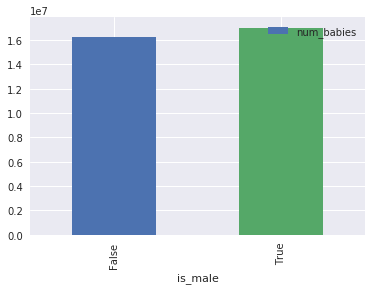

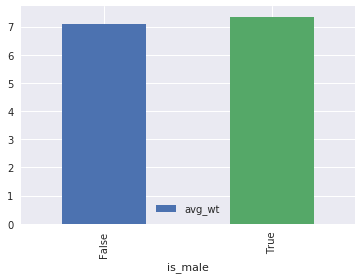

In [15]:
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

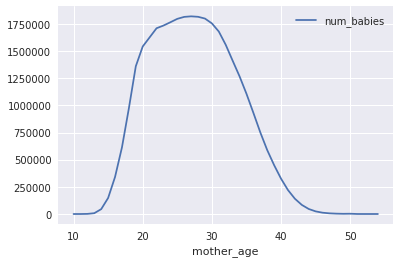

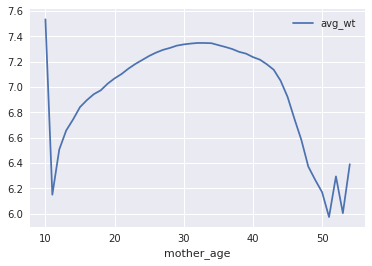

In [16]:
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

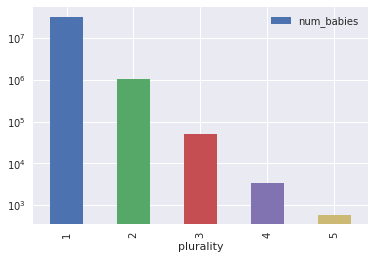

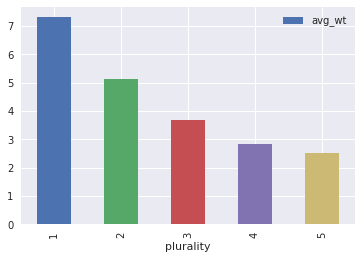

In [19]:
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', y='num_babies', logy=True, kind='bar');
df.plot(x='plurality', y='avg_wt', kind='bar');

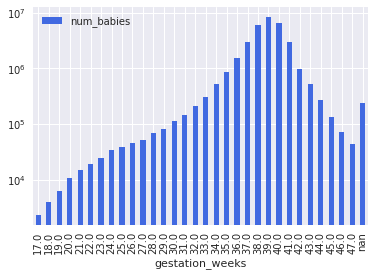

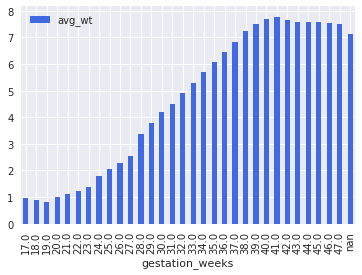

In [18]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar', color='royalblue');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar', color='royalblue');

All these factors seem to play a part in the baby's weight.  Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies.  Twins, triplets, etc. are lower weight than single births.  Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the rest of this notebook, we will use machine learning to combine all of these factors to come up with a prediction of a baby's weight.

<h2> Creating a ML dataset using Dataflow </h2>
<p>
I'm going to use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files. 

Instead of using Beam/Dataflow, I had three other options:
<ol>
<li> Use Cloud Dataprep to visually author a Dataflow pipeline. Cloud Dataprep also allows me to explore the data, so we could have avoided much of the handcoding of Python/Seaborn calls above as well!
<li> Read from BigQuery directly using TensorFlow. 
<li> Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage.
</ol>
<p>

However, in this case, I want to do some preprocessing. I want to modify the data such that we can simulate what is known if no ultrasound has been performed. If I didn't need preprocessing, I could have used the web console. Also, I prefer to script it out rather than run queries on the user interface. Therefore, I am using Cloud Dataflow for the preprocessing.

In [15]:
import apache_beam as beam
import datetime

def to_csv(rowdict):
    # pull columns from BQ and create a line
    import hashlib
    import copy
    CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')
    
    # create synthetic data where we assume that no ultrasound has been performed
    # and so we don't know sex of the baby. Let's assume that we can tell the difference
    # between single and multiple, but that the errors rates in determining exact number
    # is difficult in the absence of an ultrasound.
    no_ultrasound = copy.deepcopy(rowdict)
    w_ultrasound = copy.deepcopy(rowdict)

    no_ultrasound['is_male'] = 'Unknown'
    if rowdict['plurality'] > 1:
      no_ultrasound['plurality'] = 'Multiple(2+)'
    else:
      no_ultrasound['plurality'] = 'Single(1)'
      
    # Change the plurality column to strings
    w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality']-1]
    
    # Write out two rows for each input row, one with ultrasound and one without
    for result in [no_ultrasound, w_ultrasound]:
      data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
      key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
      yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
    job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    
    if in_test_mode:
        OUTPUT_DIR = './preproc'
    else:
        OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
    
    options = {
        'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
        'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
        'job_name': job_name,
        'project': PROJECT,
        'teardown_policy': 'TEARDOWN_ALWAYS',
        'max_num_workers': 3,   # CHANGE THIS IF YOU HAVE MORE QUOTA
        'no_save_main_session': True
    }
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    if in_test_mode:
        RUNNER = 'DirectRunner'
    else:
        RUNNER = 'DataflowRunner'
    p = beam.Pipeline(RUNNER, options=opts)
    query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """
  
    if in_test_mode:
        query = query + ' LIMIT 100' 
  
    for step in ['train', 'eval']:
        if step == 'train':
            selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) < 3'.format(query)
        else:
            selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) = 3'.format(query)

        (p 
         | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=selquery, use_standard_sql=True))
         | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
         | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
        )
 
    job = p.run()
  
preprocess(in_test_mode=False)

/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)


You may get a warning about access scopes. It's safe to ignore this.

Note that after you launch this, the actual processing is happening on the Cloud. Go to the GCP web console to the Dataflow section and monitor the running job. You'll see a job that's running. If you click it, you should get a screen like this. It took about <b>55 minutes</b> for me.



<img src="dataflow.png" width="500"/>

Once the job has completed, run the cell below to check the location of the are processed files.

In [18]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

gs://cloud-training-demos-ml/babyweight/preproc/eval.csv-00000-of-00006
gs://cloud-training-demos-ml/babyweight/preproc/train.csv-00000-of-00015


<h1>Part 2: Developing a Machine Learning Model using TensorFlow and Cloud ML Engine</h1>

<h2> Creating a TensorFlow model using the Estimator API </h2>
<p>
First, write an input_fn to read the data.

In [42]:
import hashlib
import shutil
import numpy as np
import tensorflow as tf

We may get a few warnings when we run this. Don't worry about them. 

In [147]:
CSV_COLUMNS = 'fraud_probability,date,trans_id,acct_id,tr_type,operation,amount,balance,k_symbol,bank'.split(',')
LABEL_COLUMN = 'fraud_probability'
#KEY_COLUMN = 'key'
DEFAULTS = [[0.0], ['null'], ['null'], ['null'], ['null'], ['null'], [0.0], [0.0], ['null'], ['null']]
TRAIN_STEPS = 100

def read_dataset(prefix, pattern, batch_size=128):
    # use prefix to create filename
    filename = 'gs://{}/transaction/{}*{}*.csv'.format(BUCKET, prefix, pattern)
    if prefix == 'train':
        mode = tf.estimator.ModeKeys.TRAIN
        num_epochs = None # indefinitely
    else:
        mode = tf.estimator.ModeKeys.EVAL
        num_epochs = 1 # end-of-input after this
    
    # the actual input function passed to TensorFlow
    def _input_fn():
        # could be a path to one file or a file pattern.
        input_file_names = tf.train.match_filenames_once(filename)
        filename_queue = tf.train.string_input_producer(
            input_file_names, shuffle=True, num_epochs=num_epochs)
 
        # read CSV
        reader = tf.TextLineReader()
        _, value = reader.read_up_to(filename_queue, num_records=batch_size)
        if mode == tf.estimator.ModeKeys.TRAIN:
          value = tf.train.shuffle_batch([value], batch_size, capacity=10*batch_size, 
                                         min_after_dequeue=batch_size, enqueue_many=True, 
                                         allow_smaller_final_batch=False)
        value_column = tf.expand_dims(value, -1)
        columns = tf.decode_csv(value_column,use_quote_delim=False, record_defaults=DEFAULTS)
        #columns = tf.concat([columns,hashlib.sha224(columns).hexdigest()],1,name='key')
        features_full = dict(zip(CSV_COLUMNS, columns))
        keys_to_extract = ["tr_type","operation","amount","balance"]
        features = {key: features_full[key] for key in keys_to_extract}
        #features.pop(KEY_COLUMN)
        label = features_full.pop(LABEL_COLUMN)
        return features, label
  
    return _input_fn

Next, define the feature columns.

In [120]:
def get_wide_deep():
    # define column types
    tr_type,operation,amount,balance = \
        [\
            tf.feature_column.categorical_column_with_vocabulary_list('tr_type', 
                        ['PRIJEM', 'VYDAJ']),
            tf.feature_column.categorical_column_with_vocabulary_list('operation', 
                        ['PREVODNAUCET', 'PREVODZUCTU']),
            tf.feature_column.numeric_column('amount'),
            tf.feature_column.numeric_column('balance')
        ]
      
    # sparse columns are wide 
    wide = [tr_type,
            operation]
    
    # feature cross all the wide columns and embed into a lower dimension
    crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=2000)
    embed = tf.feature_column.embedding_column(crossed, 3)
    
    # continuous columns are deep
    deep = [amount,
           balance]
    return wide, deep

To predict with the TensorFlow model, we also need a serving input function. We will want all the inputs from our user.

In [113]:
def serving_input_fn():
    feature_placeholders = {
        'tr_type': tf.placeholder(tf.string, [None]),
        'operation': tf.placeholder(tf.string, [None]),
        'amount': tf.placeholder(tf.float32, [None]),
        'balance': tf.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

Finally, train!

In [143]:
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
from tensorflow.contrib.learn.python.learn import learn_runner

PATTERN = '00001'  # process only one of the shards, for testing purposes

def train_and_evaluate(output_dir):
    wide, deep = get_wide_deep()
    estimator = tf.estimator.DNNLinearCombinedRegressor(
                         model_dir=output_dir,
                         linear_feature_columns=wide,
                         dnn_feature_columns=deep,
                         dnn_hidden_units=[64, 32])
    train_spec=tf.estimator.TrainSpec(
                         input_fn=read_dataset('train', PATTERN),
                         max_steps=TRAIN_STEPS)
    exporter = tf.estimator.FinalExporter('exporter',serving_input_fn)
    eval_spec=tf.estimator.EvalSpec(
                         input_fn=read_dataset('eval', PATTERN),
                         steps=None,
                         exporters=exporter)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
shutil.rmtree('transaction_trained', ignore_errors=True) # start fresh each time
train_and_evaluate('transaction_trained')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f21af294790>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'transaction_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
('first{}', <tf.Tensor 'shuffle_batch:0' shape=(128,) dtype=string>)
('second{}', <tf.Tensor 'ExpandDims:0' shape=(128, 1) d

Now that we have the TensorFlow code working on a subset of the data (in the code above, I was reading only the 00000-of-x file), we can package the TensorFlow code up as a Python module and train it on Cloud ML Engine.
<p>
<h2> Training on Cloud ML Engine </h2>
<p>
Training on Cloud ML Engine requires:
<ol>
<li> Making the code a Python package
<li> Using gcloud to submit the training code to Cloud ML Engine
</ol>
<p>
The code in model.py is the same as in the above cells. I just moved it to a file so that I could package it up as a module.
(explore the <a href="babyweight/trainer">directory structure</a>).

In [2]:
%bash
grep "^def" transaction/trainer/model.py

def read_dataset(prefix, pattern, batch_size=128):
def get_wide_deep():
def serving_input_fn():
def experiment_fn(output_dir):
def train_and_evaluate(output_dir):


After moving the code to a package, make sure it works standalone. (Note the --pattern and --train_steps lines so that I am not trying to boil the ocean on my laptop). Even then, this takes about <b>a minute</b> in which you won't see any output ...

In [149]:
%bash
echo "bucket=${BUCKET}"
rm -rf transaction_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/transaction
python -m trainer.task \
   --bucket=${BUCKET} \
   --output_dir=transaction_trained \
   --job-dir=./tmp \
   --pattern="00001" --train_steps=100

bucket=fs-engineering-sandbox-demos


/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6289bbf550>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'transaction_trained/', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Runn

Once the code works in standalone mode, you can run it on Cloud ML Engine.  Because this is on the entire dataset, it will take a while. The training run took about <b> 30 min </b> for me. You can monitor the job from the GCP console in the Cloud Machine Learning Engine section.

In [150]:
%bash
OUTDIR=gs://${BUCKET}/transaction/trained_model
JOBNAME=transaction_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
#gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=$(pwd)/transaction/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   --runtime-version 1.15 \
   -- \
   --bucket=${BUCKET} \
   --output_dir=${OUTDIR} \
   --train_steps=1000

gs://fs-engineering-sandbox-demos/transaction/trained_model europe-west1 transaction_200411_155059


ERROR: (gcloud.ml-engine.jobs.submit.training) INVALID_ARGUMENT: Field: runtime_version Error: The specified runtime version '1.4' with the Python version '' is not supported or is deprecated.  Please specify a different runtime version. See https://cloud.google.com/ml-engine/docs/runtime-version-list for a list of supported versions
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The specified runtime version '1.4' with the Python version '' is
      not supported or is deprecated.  Please specify a different runtime version.
      See https://cloud.google.com/ml-engine/docs/runtime-version-list for a list
      of supported versions
    field: runtime_version


Training finished with a RMSE of about 1 lb.  Obviously, this is our first model. We could probably add in some features and do some hyper-parameter tuning to get to a lower RMSE.  I'll leave that to you.  If you create a better model, I'd love to hear about it -- please do write a short blog post about what you did, and tweet it at me -- @lak_gcp.

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/transaction/trained_model'.format(BUCKET))

In [ ]:
for pid in TensorBoard.list()['pid']:
    TensorBoard().stop(pid)
    print('Stopped TensorBoard with pid {}'.format(pid))

<table width="70%">
<tr><td><img src="weights.png"/></td><td><img src="rmse.png" /></tr>
</table>

<h2> Deploying the trained model </h2>
<p>
Deploying the trained model to act as a REST web service is a simple gcloud call.

In [3]:
%bash
gsutil ls gs://${BUCKET}/transaction/trained_model/export/exporter

gs://dataproc-2bf92515-7250-45e2-aba4-136edb989dd7-europe-west1/
gs://dataproc-3a26fde1-ea0e-438e-aaaf-2bcbb9b486c2-eu/
gs://df-4148192797717921435-ljxrwqy4aei6vgpz6qbqiolqqa/
gs://eu.artifacts.fs-engineering-sandbox-422774.appspot.com/
gs://fs-engineering-sandbox-422774-fusion/
gs://fs-engineering-sandbox-422774-ingestion/
gs://fs-engineering-sandbox-422774-lcm/
gs://fs-engineering-sandbox-422774-output-bucket/
gs://fs-engineering-sandbox-422774-repor/
gs://fs-engineering-sandbox-422774.appspot.com/
gs://fs-engineering-sandbox-demos/
gs://fsengbucket/
gs://fsengfilestore/
gs://staging.fs-engineering-sandbox-422774.appspot.com/


In [12]:
%bash
MODEL_NAME="transaction"
MODEL_VERSION="soln"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/transaction/trained_model/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version 1.15

Deleting and deploying transaction soln from gs://fs-engineering-sandbox-demos/transaction/trained_model/export/exporter/1586621648/ ... this will take a few minutes


ERROR: (gcloud.ai-platform.models.create) Resource in project [fs-engineering-sandbox-422774] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
.....................................................................................................................................................................................................................................................done.


Once this has been created, it will display 'done'.

<h2> Using the model to predict </h2>
<p>
Send a JSON request to the endpoint of the service to make it to predict a transaction's fraud probability

In [14]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

request_data = {'instances':
  [
    {
      'tr_type': 'PRIJEM',
      'operation': 'PREVODZUCTU',
      'amount': 7669,
      'balance': 8569
    },
    {
      'tr_type': 'VYDAJ',
      'operation': 'PREVODNAUCET',
      'amount': 500,
      'balance': 80000
    },
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'transaction', 'soln')
response = api.projects().predict(body=request_data, name=parent).execute()
print(json.dumps(response, sort_keys = True, indent = 4))

{
    "predictions": [
        {
            "predictions": [
                12.286073684692383
            ]
        }, 
        {
            "predictions": [
                16.60023307800293
            ]
        }
    ]
}


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License